## TP 5

In [72]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [73]:
data = pd.read_csv(r"mnist.csv")

In [74]:
data.shape

(42000, 785)

In [75]:
data = np.array(data)

In [76]:
n, m = data.shape
np.random.shuffle(data)

data_test = data[0:1000].T
X_test = data_test[1:n]
y_test = data_test[0]

X_test = X_test / 255

data_train = data[1000:n].T
X_train = data_train[1:n]
y_train = data_train[0]

X_train = X_train / 255 
(n,m)

(42000, 785)

In [77]:
(X_test.shape, X_train.shape)

((784, 1000), (784, 41000))

In [78]:
(y_test.shape, y_train.shape)

((1000,), (41000,))

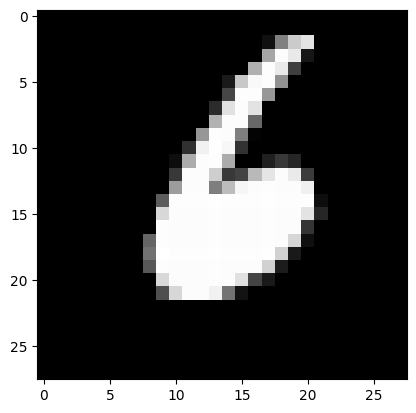

In [79]:
# 1.4)
plt.imshow(X_train[:, 0].reshape((28, 28)))


In [80]:
def initialisation():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1)
    w2 = np.random.rand(10, 10)
    b2 = np.random.rand(10, 1)
    return w1, b1, w2, b2


In [81]:
def relu(Z):
    return np.maximum(0.01*Z, 0)

In [82]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

In [83]:
def propagation_en_avant(X, w1, b1, w2, b2):
    z1 = w1.dot(X) + b1
    a1 = relu(z1)
    
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)

    return z1, a1, z2, a2

In [84]:
def derive_relu(z):
    return (z > 0)

In [85]:
def y_encode(Y):
    y_encod = np.zeros((Y.size, Y.max() + 1))
    y_encod[np.arange(Y.size), Y] = 1
    return y_encod.T

In [86]:
def retro_propagation(z1, a1, z2, a2, w1, w2, X, Y):
    y_encod = y_encode(Y)
    dz2 = a2 - y_encod  
    dw2 = 1 / m * dz2.dot(a1.T)
    db2 = 1 / m * np.sum(dz2)
    dz1 = w2.T.dot(dz2) * derive_relu(z1)
    dw1 = 1 / m * dz1.dot(X.T)
    db1 = 1 / m * np.sum(dz1)
    
    return dw1, db1, dw2, db2

def prediction(a2):
    return np.argmax(a2, 0)

def accuracy(y_pred, Y):
    print(y_pred, Y)
    return np.sum(y_pred == Y) / Y.size

In [87]:
def mettre_a_jour(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    
    return w1, b1, w2, b2


def mettre_a_jour_momentum(w1, b1, w2, b2, dw1, db1, dw2, db2, v_w1, v_b1, v_w2, v_b2, alpha, beta):
    # Mise à jour des vitesses
    v_w1 = beta * v_w1 + (1 - beta) * dw1
    v_b1 = beta * v_b1 + (1 - beta) * db1
    v_w2 = beta * v_w2 + (1 - beta) * dw2
    v_b2 = beta * v_b2 + (1 - beta) * db2

    # Mise à jour des paramètres avec Momentum
    w1 = w1 - alpha * v_w1
    b1 = b1 - alpha * v_b1
    w2 = w2 - alpha * v_w2
    b2 = b2 - alpha * v_b2
    
    return w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2


def descente_gradient_momentum(X, Y, alpha, beta, iterations):
    w1, b1, w2, b2 = initialisation()
    trajectoire = []

    # Initialisation des vitesses pour Momentum
    v_w1, v_b1, v_w2, v_b2 = np.zeros_like(w1), np.zeros_like(b1), np.zeros_like(w2), np.zeros_like(b2)

    for i in range(iterations):
        # Propagation en avant
        z1, a1, z2, a2 = propagation_en_avant(X, w1, b1, w2, b2)
        
        # Rétropropagation
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1, w2, X, Y)
        
        # Mise à jour avec Momentum
        w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2 = mettre_a_jour_momentum(
            w1, b1, w2, b2, dw1, db1, dw2, db2, 
            v_w1, v_b1, v_w2, v_b2, alpha, beta
        )
        
        # Affichage de la précision tous les 10 itérations
        if i % 10 == 0:
            print("Iteration: ", i)
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))
            
        trajectoire.append((w1.copy(), w2.copy()))

    
    return w1, b1, w2, b2 , trajectoire


In [88]:
def descente_gradient_nesterov(X, Y, alpha, beta, iterations):
    w1, b1, w2, b2 = initialisation()
    
    # Initialisation des vitesses pour Nesterov
    v_w1, v_b1, v_w2, v_b2 = np.zeros_like(w1), np.zeros_like(b1), np.zeros_like(w2), np.zeros_like(b2)
    
    trajectoire = []

    for i in range(iterations):
        # Anticipation : regarde un pas en avant
        w1_lookahead = w1 + beta * v_w1
        b1_lookahead = b1 + beta * v_b1
        w2_lookahead = w2 + beta * v_w2
        b2_lookahead = b2 + beta * v_b2

        # Propagation en avant avec les poids anticipés
        z1, a1, z2, a2 = propagation_en_avant(X, w1_lookahead, b1_lookahead, w2_lookahead, b2_lookahead)
        
        # Rétropropagation du gradient
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1_lookahead, w2_lookahead, X, Y)
        
        # Mise à jour avec Nesterov Momentum
        w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2 = mettre_a_jour_nesterov(
            w1, b1, w2, b2, dw1, db1, dw2, db2, 
            v_w1, v_b1, v_w2, v_b2, alpha, beta
        )

        # Affichage de la précision tous les 10 itérations
        if i % 10 == 0:
            print("Iteration: ", i)
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))
        
        trajectoire.append((w1.copy(), w2.copy()))
    
    return w1, b1, w2, b2 , trajectoire

def mettre_a_jour_nesterov(w1, b1, w2, b2, dw1, db1, dw2, db2, v_w1, v_b1, v_w2, v_b2, alpha, beta):
    # Mise à jour des vitesses avec le gradient au point anticipé
    v_w1 = beta * v_w1 - alpha * dw1
    v_b1 = beta * v_b1 - alpha * db1
    v_w2 = beta * v_w2 - alpha * dw2
    v_b2 = beta * v_b2 - alpha * db2

    # Mise à jour des poids avec la nouvelle vitesse
    w1 = w1 + v_w1
    b1 = b1 + v_b1
    w2 = w2 + v_w2
    b2 = b2 + v_b2
    
    return w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2

In [89]:
def descente_newton(X, Y, iterations, eps=1e-8):
    w1, b1, w2, b2 = initialisation()
    trajectoire = []
    
    for i in range(iterations):
        # Propagation en avant
        z1, a1, z2, a2 = propagation_en_avant(X, w1, b1, w2, b2)
        
        # Rétropropagation
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1, w2, X, Y)

        # Calcul de la Hessienne (approximation diagonale)
        H_w1, H_b1, H_w2, H_b2 = hessienne(w1, b1, w2, b2, X)

        # Mise à jour des poids avec Newton
        w1, b1, w2, b2 = mettre_a_jour_newton(w1, b1, w2, b2, dw1, db1, dw2, db2, H_w1, H_b1, H_w2, H_b2)

        # Vérification de la convergence
        if np.linalg.norm(dw1) < eps and np.linalg.norm(dw2) < eps:
            print(f"Convergence atteinte en {i+1} itérations.")
            break

        # Affichage tous les 10 itérations
        if i % 10 == 0:
            print(f"Iteration: {i}")
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))
        
        trajectoire.append((w1.copy(), w2.copy()))

    return w1, b1, w2, b2 , trajectoire

def hessienne(w1, b1, w2, b2, X):
    """
    Approximation de la matrice Hessienne (ici, on suppose qu'elle est diagonale).
    En pratique, pour un réseau complexe, calculer la Hessienne exacte est coûteux.
    """
    H_w1 = np.eye(w1.shape[0]) * (np.abs(w1) + 1e-4)  # Ajout d'une petite valeur pour éviter l'inversion instable
    H_b1 = np.eye(b1.shape[0]) * (np.abs(b1) + 1e-4)
    H_w2 = np.eye(w2.shape[0]) * (np.abs(w2) + 1e-4)
    H_b2 = np.eye(b2.shape[0]) * (np.abs(b2) + 1e-4)
    
    return H_w1, H_b1, H_w2, H_b2

def mettre_a_jour_newton(w1, b1, w2, b2, dw1, db1, dw2, db2, H_w1, H_b1, H_w2, H_b2):
    """
    Mise à jour des poids en utilisant la méthode de Newton : 
    w_new = w - H^(-1) * gradient
    """
    w1 = w1 - np.linalg.inv(H_w1) @ dw1
    b1 = b1 - np.linalg.inv(H_b1) @ db1
    w2 = w2 - np.linalg.inv(H_w2) @ dw2
    b2 = b2 - np.linalg.inv(H_b2) @ db2
    
    return w1, b1, w2, b2

In [90]:
def descente_gradient_adam(X, Y, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, iterations=500):
    w1, b1, w2, b2 = initialisation()
    trajectoire = []

    # Initialisation des moyennes mobiles
    m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1)
    m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
    m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
    m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)

    for i in range(1, iterations + 1):  # Début à 1 pour la correction du biais
        # Propagation en avant
        z1, a1, z2, a2 = propagation_en_avant(X, w1, b1, w2, b2)

        # Rétropropagation
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1, w2, X, Y)

        # Mise à jour avec Adam
        w1, b1, w2, b2, m_w1, v_w1, m_b1, v_b1, m_w2, v_w2, m_b2, v_b2 = mettre_a_jour_adam(
            w1, b1, w2, b2, dw1, db1, dw2, db2,
            m_w1, v_w1, m_b1, v_b1, m_w2, v_w2, m_b2, v_b2,
            alpha, beta1, beta2, epsilon, i
        )

        # Affichage tous les 10 itérations
        if i % 10 == 0:
            print(f"Iteration: {i}")
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))

        trajectoire.append((w1.copy(), w2.copy()))

    return w1, b1, w2, b2 , trajectoire

def mettre_a_jour_adam(w1, b1, w2, b2, dw1, db1, dw2, db2,
                        m_w1, v_w1, m_b1, v_b1, m_w2, v_w2, m_b2, v_b2,
                        alpha, beta1, beta2, epsilon, t):
    """
    Mise à jour des poids avec l'optimiseur Adam.
    """
    # Moyenne mobile des gradients
    m_w1 = beta1 * m_w1 + (1 - beta1) * dw1
    m_b1 = beta1 * m_b1 + (1 - beta1) * db1
    m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
    m_b2 = beta1 * m_b2 + (1 - beta1) * db2

    # Moyenne mobile des carrés des gradients
    v_w1 = beta2 * v_w1 + (1 - beta2) * (dw1 ** 2)
    v_b1 = beta2 * v_b1 + (1 - beta2) * (db1 ** 2)
    v_w2 = beta2 * v_w2 + (1 - beta2) * (dw2 ** 2)
    v_b2 = beta2 * v_b2 + (1 - beta2) * (db2 ** 2)

    # Correction du biais
    m_w1_hat = m_w1 / (1 - beta1 ** t)
    m_b1_hat = m_b1 / (1 - beta1 ** t)
    m_w2_hat = m_w2 / (1 - beta1 ** t)
    m_b2_hat = m_b2 / (1 - beta1 ** t)

    v_w1_hat = v_w1 / (1 - beta2 ** t)
    v_b1_hat = v_b1 / (1 - beta2 ** t)
    v_w2_hat = v_w2 / (1 - beta2 ** t)
    v_b2_hat = v_b2 / (1 - beta2 ** t)

    # Mise à jour des poids
    w1 = w1 - alpha * m_w1_hat / (np.sqrt(v_w1_hat) + epsilon)
    b1 = b1 - alpha * m_b1_hat / (np.sqrt(v_b1_hat) + epsilon)
    w2 = w2 - alpha * m_w2_hat / (np.sqrt(v_w2_hat) + epsilon)
    b2 = b2 - alpha * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)

    return w1, b1, w2, b2, m_w1, v_w1, m_b1, v_b1, m_w2, v_w2, m_b2, v_b2

In [91]:
def descente_gradient_rmsprop(X, Y, alpha=0.001, beta=0.9, epsilon=1e-8, iterations=500):
    w1, b1, w2, b2 = initialisation()
    trajectoire=[]
    
    # Initialisation des moyennes mobiles des gradients
    v_w1, v_b1 = np.zeros_like(w1), np.zeros_like(b1)
    v_w2, v_b2 = np.zeros_like(w2), np.zeros_like(b2)

    for i in range(1, iterations + 1):
        # Propagation en avant
        z1, a1, z2, a2 = propagation_en_avant(X, w1, b1, w2, b2)

        # Rétropropagation
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1, w2, X, Y)

        # Mise à jour avec RMSprop
        w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2 = mettre_a_jour_rmsprop(
            w1, b1, w2, b2, dw1, db1, dw2, db2,
            v_w1, v_b1, v_w2, v_b2,
            alpha, beta, epsilon
        )

        # Affichage tous les 10 itérations
        if i % 10 == 0:
            print(f"Iteration: {i}")
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))
        
        trajectoire.append((w1.copy(), w2.copy()))

    return w1, b1, w2, b2 , trajectoire

def mettre_a_jour_rmsprop(w1, b1, w2, b2, dw1, db1, dw2, db2,
                          v_w1, v_b1, v_w2, v_b2,
                          alpha, beta, epsilon):
    """
    Mise à jour des poids avec l'optimiseur RMSprop.
    """
    # Mise à jour de la moyenne mobile des carrés des gradients
    v_w1 = beta * v_w1 + (1 - beta) * (dw1 ** 2)
    v_b1 = beta * v_b1 + (1 - beta) * (db1 ** 2)
    v_w2 = beta * v_w2 + (1 - beta) * (dw2 ** 2)
    v_b2 = beta * v_b2 + (1 - beta) * (db2 ** 2)

    # Mise à jour des poids
    w1 = w1 - alpha * dw1 / (np.sqrt(v_w1) + epsilon)
    b1 = b1 - alpha * db1 / (np.sqrt(v_b1) + epsilon)
    w2 = w2 - alpha * dw2 / (np.sqrt(v_w2) + epsilon)
    b2 = b2 - alpha * db2 / (np.sqrt(v_b2) + epsilon)

    return w1, b1, w2, b2, v_w1, v_b1, v_w2, v_b2 

In [92]:

def descente_gradient(X, Y, alpha, iterations):
    w1, b1, w2, b2 = initialisation()
    trajectoire = []
    for i in range(iterations):
        z1, a1, z2, a2 = propagation_en_avant(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = retro_propagation(z1, a1, z2, a2, w1, w2, X, Y)
        w1, b1, w2, b2 = mettre_a_jour(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            y_pred = prediction(a2)
            print(accuracy(y_pred, Y))
        trajectoire.append((w1.copy() , w2.copy()))
    return w1, b1, w2, b2 , trajectoire

In [93]:
def nouvelles_predictions(X, w1, b1, w2, b2):
    _, _, _, a2 = propagation_en_avant(X, w1, b1, w2, b2)
    y_pred = prediction(a2)
    return y_pred

In [94]:
def test_prediction(index, w1, b1, w2, b2):
    prediction = nouvelles_predictions(X_test[:, index, None], w1, b1, w2, b2)
    etiquette = y_test[index]
    print("Prediction:", prediction)
    print("Etiquette:", etiquette)

    image_actuelle = X_test[:, index]
    image_actuelle = image_actuelle.reshape((28, 28)) * 255

    plt.gray()
    plt.imshow(image_actuelle)

In [96]:
# Standard Gradient Descent
w1_gd, b1_gd, w2_gd, b2_gd, trajectoire_gd = descente_gradient(X_train, y_train, alpha=0.1, iterations=500)

Iteration:  0
[1 1 1 ... 1 1 1] [6 3 9 ... 7 0 1]
0.11126829268292683
Iteration:  10
[8 3 9 ... 7 0 8] [6 3 9 ... 7 0 1]
0.4621707317073171
Iteration:  20
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.5816829268292683
Iteration:  30
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7900731707317074
Iteration:  40
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7844878048780488
Iteration:  50
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8300731707317073
Iteration:  60
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8534634146341463
Iteration:  70
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8655609756097561
Iteration:  80
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8904634146341464
Iteration:  90
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8888292682926829
Iteration:  100
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8820243902439024
Iteration:  110
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8999512195121951
Iteration:  120
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9009024390243903
Iteration:  130
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8994878048780488
Iteration:  140


In [97]:
# Gradient Descent with Momentum
w1_momentum, b1_momentum, w2_momentum, b2_momentum, trajectoire_momentum = descente_gradient_momentum(X_train, y_train, alpha=0.1, iterations=500, beta=0.9)

Iteration:  0
[8 8 8 ... 8 8 8] [6 3 9 ... 7 0 1]
0.09660975609756098
Iteration:  10
[8 8 8 ... 8 0 8] [6 3 9 ... 7 0 1]
0.18373170731707317
Iteration:  20
[1 3 7 ... 7 0 1] [6 3 9 ... 7 0 1]
0.42246341463414633
Iteration:  30
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.728170731707317
Iteration:  40
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8013902439024391
Iteration:  50
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8410731707317073
Iteration:  60
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8654634146341463
Iteration:  70
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8784146341463415
Iteration:  80
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8860243902439024
Iteration:  90
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8913658536585366
Iteration:  100
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8954878048780488
Iteration:  110
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8977317073170732
Iteration:  120
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9007560975609756
Iteration:  130
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9029756097560976
Iteration:  140

In [98]:
# Nesterov Accelerated Gradient (NAG)
w1_nag, b1_nag, w2_nag, b2_nag, trajectoire_nag = descente_gradient_nesterov(X_train, y_train, alpha=0.1, iterations=500, beta=0.9)

Iteration:  0
[1 1 1 ... 1 1 1] [6 3 9 ... 7 0 1]
0.11126829268292683
Iteration:  10
[9 1 9 ... 9 0 1] [6 3 9 ... 7 0 1]
0.3248780487804878
Iteration:  20
[4 1 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.5072682926829268
Iteration:  30
[4 1 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.5735365853658536
Iteration:  40
[4 1 4 ... 7 0 2] [6 3 9 ... 7 0 1]
0.5511219512195122
Iteration:  50
[6 1 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.6261219512195122
Iteration:  60
[6 1 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.5803414634146341
Iteration:  70
[6 0 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.6306585365853659
Iteration:  80
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7621463414634146
Iteration:  90
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.5818536585365853
Iteration:  100
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7104634146341463
Iteration:  110
[6 1 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.6369512195121951
Iteration:  120
[6 1 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.6558780487804878
Iteration:  130
[6 1 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.6172439024390244
Iteration:  140


In [99]:
# RMSProp
w1_rmsprop, b1_rmsprop, w2_rmsprop, b2_rmsprop, trajectoire_rmsprop = descente_gradient_rmsprop(X_train, y_train, alpha=0.1, iterations=500, beta=0.9)

Iteration: 10
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7402439024390244
Iteration: 20
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.7894146341463415
Iteration: 30
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8354146341463414
Iteration: 40
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8391463414634146
Iteration: 50
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.875780487804878
Iteration: 60
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8748536585365854
Iteration: 70
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8800243902439024
Iteration: 80
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8999756097560976
Iteration: 90
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.903609756097561
Iteration: 100
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9050975609756098
Iteration: 110
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8939268292682927
Iteration: 120
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8950487804878049
Iteration: 130
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9109512195121952
Iteration: 140
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9044634146341464
Iteration: 150
[6 3 9 ... 7 0 1

In [102]:
# Newton's Method
w1_newton, b1_newton, w2_newton, b2_newton, trajectoire_newton = descente_newton(X_train, y_train, iterations=500)

ValueError: operands could not be broadcast together with shapes (10,10) (10,784) 

In [103]:
# Adam Optimizer
w1_adam, b1_adam, w2_adam, b2_adam, trajectoire_adam = descente_gradient_adam(X_train, y_train, alpha=0.1, iterations=500, beta1=0.9, beta2=0.99)

Iteration: 10
[2 3 4 ... 4 0 8] [6 3 9 ... 7 0 1]
0.5104146341463415
Iteration: 20
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8002439024390244
Iteration: 30
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.847609756097561
Iteration: 40
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.8778292682926829
Iteration: 50
[6 3 4 ... 7 0 1] [6 3 9 ... 7 0 1]
0.896390243902439
Iteration: 60
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9066341463414634
Iteration: 70
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9136829268292683
Iteration: 80
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.918609756097561
Iteration: 90
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.921829268292683
Iteration: 100
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9244878048780488
Iteration: 110
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9263658536585366
Iteration: 120
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9279756097560976
Iteration: 130
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.929439024390244
Iteration: 140
[6 3 9 ... 7 0 1] [6 3 9 ... 7 0 1]
0.9309024390243903
Iteration: 150
[6 3 9 ... 7 0 1] [

Prediction: [0]
Etiquette: 0


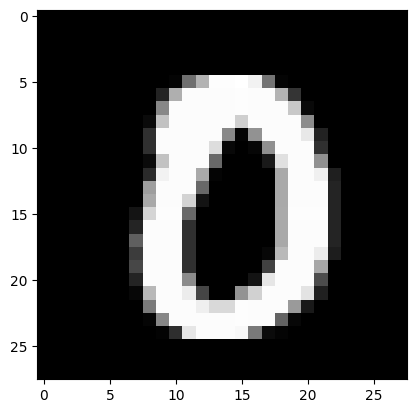

In [ ]:

# Trajectoires pour les trois méthodes
trajectoires = [
    ("descente de gradient", trajectoire_gd,)
    ("momentum", trajectoire_momentum, )
    ("nesterov", trajectoire_nag),
    ("newton", trajectoire_newton),
    ("adam", trajectoire_adam)
]

# Création d'une grille pour les valeurs de w
x1 = np.linspace(-5, 3, 100)
x2 = np.linspace(-7, 1, 100)
w_grid = np.meshgrid(x1, x2)
z = f(w_grid)

# Création de la figure pour afficher les graphiques
fig = plt.figure(figsize=(20, 10))

# Premier graphique : Surface 3D de la fonction f(w)
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(w_grid[0], w_grid[1], z, cmap='plasma', alpha=0.7)
ax1.set_title("Surface 3D de la fonction f(w)")

# Graphiques individuels pour chaque méthode
for i, (nom, traj) in enumerate(trajectoires):
    ax = fig.add_subplot(2, 3, i + 2)  # 2 rows, 3 columns, starting from position 2
    ax.contour(w_grid[0], w_grid[1], z, cmap='plasma', levels=20)
    ax.plot(traj[:, 0], traj[:, 1], marker="o", linestyle="-", markersize=3, label=nom)
    ax.set_title(f"Trajectoire de {nom}")
    ax.legend()

plt.tight_layout()
plt.show()